In [1]:
import xarray as xr
import numpy as np
import netCDF4
from matplotlib import pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import iris
import iris.quickplot as qplt
import pandas as pd
from scipy import stats
import cartopy.feature as cfeature

In [2]:
# d18O from 1850-2005
d18O_last_sw = xr.open_dataarray('/data/keeling/a/anayrp2/CESM/d18O_last.nc')
d18O_last_sw.load();

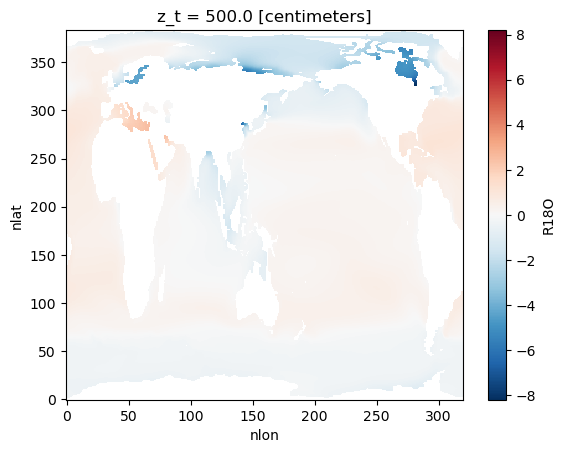

In [3]:
# global mean d18O from 1850-2005
d18O_last_sw_mean = d18O_last_sw.sel(time=slice('1955','2005')).mean(dim='time')
d18O_last_sw_mean.plot()

In [4]:
# dropping conflicting coordinates (keeping TLONG and TLAT)
d18O_a = d18O_last_sw_mean.drop('ULONG')
d18O_b = d18O_a.drop('ULAT')
d18O_b;

/data/keeling/a/anayrp2/miniconda3/envs/paleo/lib/python3.9/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn(


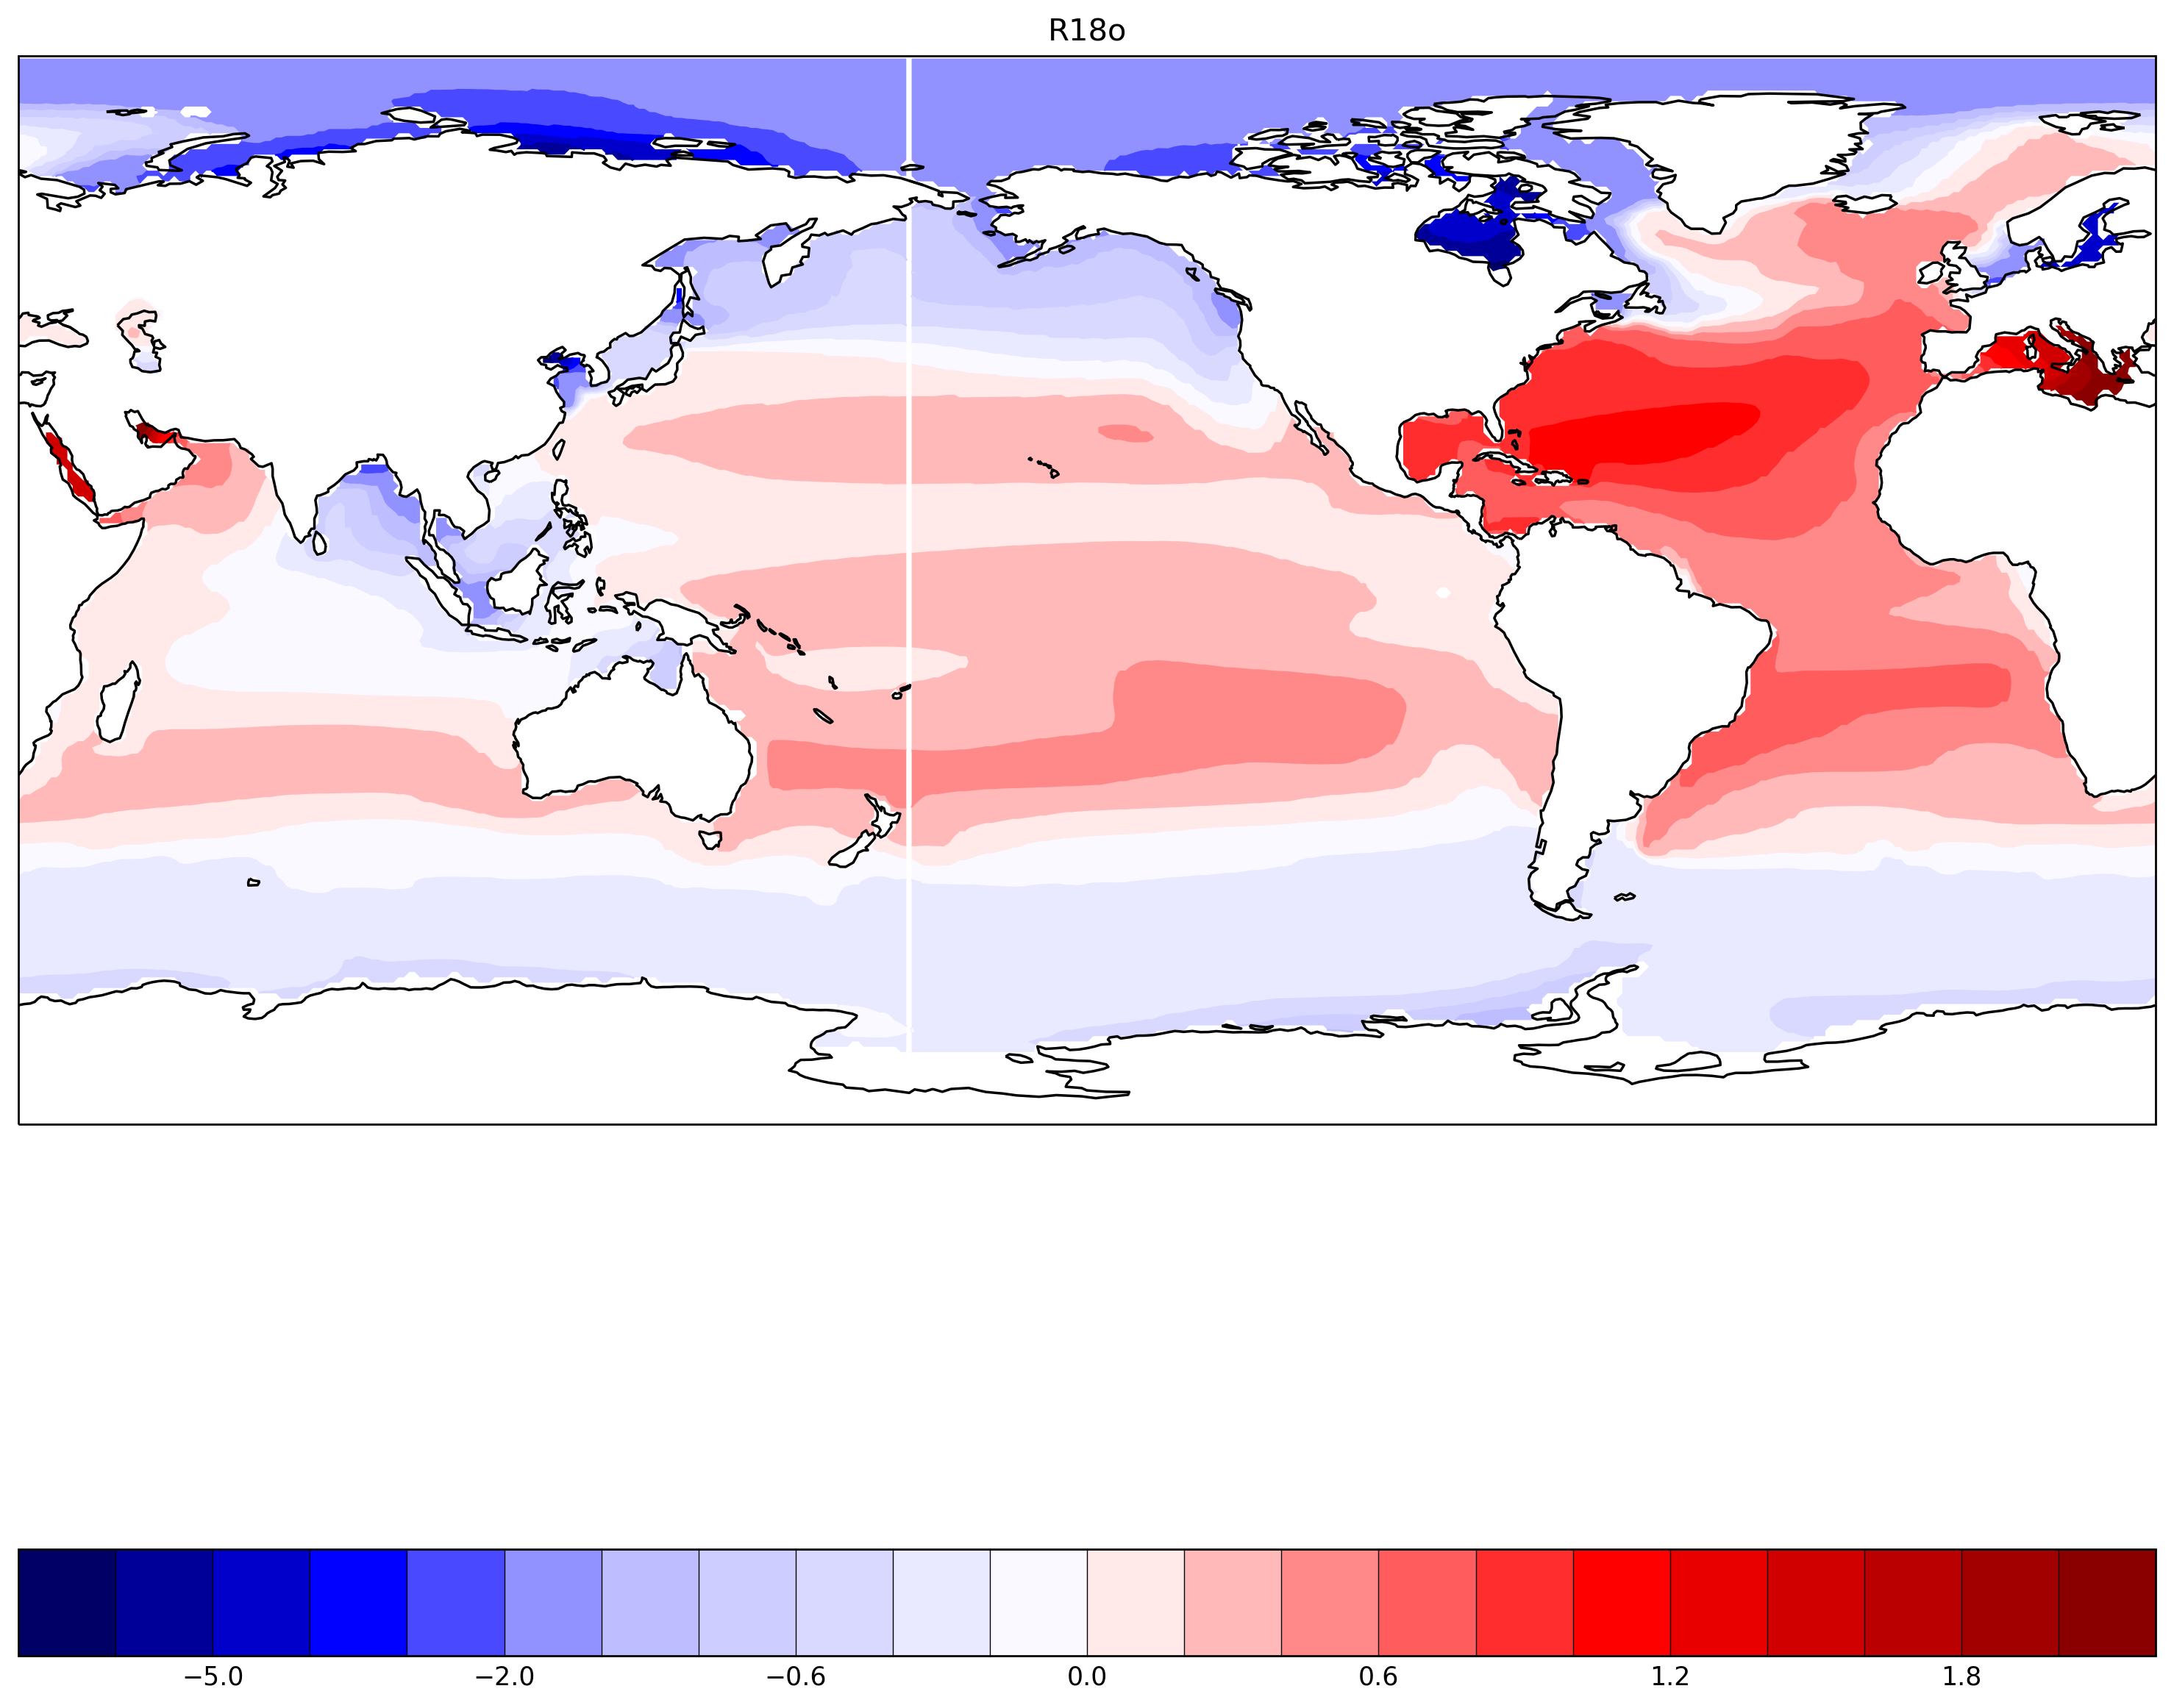

In [5]:
# same as plot above, recreating brady et al 2019 figure 8b
cube = d18O_b.to_iris()

pcarree = ccrs.PlateCarree()
new_cube, extent = iris.analysis.cartography.project(cube, pcarree,nx=400, ny=200)
fig = plt.figure(figsize=[15,20], dpi=250)
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=-150.0))
ax.set_global()
ax.coastlines()
levels = [-7,-6, -5, -4 ,-3 ,-2, -1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2]
norm = mcolors.TwoSlopeNorm(vmin=levels[0], vmax=levels[-1], vcenter=0)

qplt.contourf(new_cube,cmap='seismic',levels=levels, norm=norm)
plt.show()

In [6]:
# observational data from conroy et al 2017
conroy = pd.read_csv('/data/keeling/a/anayrp2/CESM/palo20415-sup-0002-datas1.csv')

In [7]:
# formatting column names
conroy.columns = conroy.columns.to_series().apply(lambda x: x.strip())
df = conroy[["Lon", "Lat", "Date", "Comments"]]
df.head();

In [8]:
# adjusting column data types
df['Date']= pd.to_datetime(df['Date'])
# df.dtypes

/tmp/ipykernel_10440/1909285708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']= pd.to_datetime(df['Date'])


In [9]:
# breaking the exact date into just month and year so we can use the iCESM monthly output
df['DateNew'] = df['Date'].map(lambda x: pd.datetime(x.year - 10, x.month, x.day))
#df.head();

/tmp/ipykernel_10440/871582041.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['DateNew'] = df['Date'].map(lambda x: pd.datetime(x.year - 10, x.month, x.day))
/tmp/ipykernel_10440/871582041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DateNew'] = df['Date'].map(lambda x: pd.datetime(x.year - 10, x.month, x.day))


In [10]:
# combining month and year and changing its data type
df['year'] = pd.DatetimeIndex(df['DateNew']).year
df['month'] = pd.DatetimeIndex(df['DateNew']).month
df['month_year'] = pd.to_datetime(df['DateNew']).dt.to_period('M')
#df.head();

/tmp/ipykernel_10440/1747867018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.DatetimeIndex(df['DateNew']).year
/tmp/ipykernel_10440/1747867018.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = pd.DatetimeIndex(df['DateNew']).month
/tmp/ipykernel_10440/1747867018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [11]:
# making the 6 needed datasets (s = spatial and t = temporal)
png = df.loc[df['Comments'] == 'PNG temporal data']
palau = df.loc[df['Comments'] == 'Palau temporal data']
kiri_s = df.loc[df['Comments'] == 'Kiritimati spatial data']
kiri_t = df.loc[df['Comments'] == 'Kiritimati ocean side temporal data']
gala_t = df.loc[df['Comments'] == 'Galapagos temporal data']
gala_s = df.loc[df['Comments'] == 'Galapagos spatial data']

In [12]:
# not really sure if this was necessary (or if it did anything useful)
png.set_index(['Lon', 'Lat', 'Date'])
palau.set_index(['Lon', 'Lat', 'Date'])
kiri_s.set_index(['Lon', 'Lat', 'Date'])
kiri_t.set_index(['Lon', 'Lat', 'Date'])
gala_t.set_index(['Lon', 'Lat', 'Date'])
gala_s.set_index(['Lon', 'Lat', 'Date']);

In [13]:
# array of the datasets
locations = [png, palau, kiri_s, kiri_t, gala_t, gala_s]
# for x in range(len(locations)):
#     print(locations[x])

In [14]:
# getting the bounds of dates in each dataset
for x in range(len(locations)):
    locations[x].time_min = locations[x].month_year.min()
    locations[x].time_max = locations[x].month_year.max()

In [15]:
for x in range(len(locations)):
    print(locations[x].time_min, locations[x].time_max)

2003-05 2004-07
2003-02 2004-11
2002-05 2003-08
2003-08 2004-08
2002-10 2005-01
2002-09 2005-01


In [16]:
# reducing the 6 datasets to just the time frames we need
png_d18O = d18O_last_sw.sel(time=slice('2003-05', '2004-07'))
palau_d18O = d18O_last_sw.sel(time=slice('2003-02', '2004-11'))
kiri_s_d18O = d18O_last_sw.sel(time=slice('2002-05', '2003-08'))
kiri_t_d18O = d18O_last_sw.sel(time=slice('2003-08', '2004-08'))
gala_t_d18O = d18O_last_sw.sel(time=slice('2002-10', '2005-01'))
gala_s_d18O = d18O_last_sw.sel(time=slice('2002-09', '2005-01'))

In [17]:
# function to subsample iCESM data at grid point nearest to the actual coordinates
def pluck_data(ds,lon_target,lat_target):
    ind_lat=np.argmin(np.abs(ds.TLAT[:,0].values-lat_target))
    ind_lon=np.argmin(np.abs(ds.TLONG[0,:].values-lon_target))
    return ds[:,ind_lat,ind_lon]

In [18]:
# the following cells further reduce the datasets, leaving us only with data at the desired grid point
# the spatial datasets needed to be plucked at many different coordinates in accordance with the Conroy dataset

In [19]:
lat_target=-2.061
lon_target=147.428
png_d18O_data=pluck_data(png_d18O,lon_target,lat_target)

In [20]:
lat_target = 7.317
lon_target = 134.461 
palau_d18O_data= pluck_data(palau_d18O, lon_target, lat_target)

In [21]:
kiri_s_d18O_data = []
for i in range(139,162):
    lon_target = kiri_s['Lon']
    lat_target = kiri_s['Lat']
    kiri_s_d18O_data.append(pluck_data(kiri_s_d18O, lon_target[i], lat_target[i]))
kiri_s_d18O_data_f = list(np.concatenate(kiri_s_d18O_data).flat)

In [22]:
lat_target = 2.0
lon_target = -157.483
kiri_t_d18O_data= pluck_data(kiri_t_d18O, lon_target, lat_target)

In [23]:
lat_target = -0.744
lon_target = -90.303
gala_t_d18O_data= pluck_data(gala_t_d18O, lon_target, lat_target)

In [24]:
gala_s_d18O_data = []
for i in range(328,465):
    lon_target = gala_s['Lon']
    lat_target = gala_s['Lat']
    gala_s_d18O_data.append(pluck_data(gala_s_d18O, lon_target[i], lat_target[i]))
gala_s_d18O_data_f = list(np.concatenate(gala_s_d18O_data).flat)

In [25]:
# the same exercise is done for the salinity data below

In [26]:
salt_last_sw = xr.open_dataarray('/data/keeling/a/anayrp2/CESM/salt_last.nc')

In [27]:
salt_last_sw.load();

In [28]:
png_salt = salt_last_sw.sel(time=slice('2003-05', '2004-07'))
palau_salt = salt_last_sw.sel(time=slice('2003-02', '2004-11'))
kiri_s_salt = salt_last_sw.sel(time=slice('2002-05', '2003-08'))
kiri_t_salt = salt_last_sw.sel(time=slice('2003-08', '2004-08'))
gala_t_salt = salt_last_sw.sel(time=slice('2002-10', '2005-01'))
gala_s_salt = salt_last_sw.sel(time=slice('2002-09', '2005-01'))

In [29]:
lat_target=-2.061
lon_target=147.428
png_salt_data=pluck_data(png_salt,lon_target,lat_target)

In [30]:
lat_target = 7.317
lon_target = 134.461 
palau_salt_data= pluck_data(palau_salt, lon_target, lat_target)

In [31]:
kiri_s_salt_data = []
for i in range(139,162):
    lon_target = kiri_s['Lon']
    lat_target = kiri_s['Lat']
    kiri_s_salt_data.append(pluck_data(kiri_s_salt, lon_target[i], lat_target[i]))
kiri_s_salt_data_f = list(np.concatenate(kiri_s_salt_data).flat)

In [32]:
lat_target = 2.0
lon_target = -157.483
kiri_t_salt_data= pluck_data(kiri_t_salt, lon_target, lat_target)

In [33]:
lat_target = -0.744
lon_target = -90.303
gala_t_salt_data= pluck_data(gala_t_salt, lon_target, lat_target)

In [34]:
gala_s_salt_data = []
for i in range(328,465):
    lon_target = gala_s['Lon']
    lat_target = gala_s['Lat']
    gala_s_salt_data.append(pluck_data(gala_s_salt, lon_target[i], lat_target[i]))
gala_s_salt_data_f = list(np.concatenate(gala_s_salt_data).flat)

In [35]:
kiri_s_salt_data_fa = np.array(kiri_s_salt_data_f)
kiri_s_d18O_data_fa = np.array(kiri_s_d18O_data_f)
gala_s_salt_data_fa = np.array(gala_s_salt_data_f)
gala_s_d18O_data_fa = np.array(gala_s_d18O_data_f)

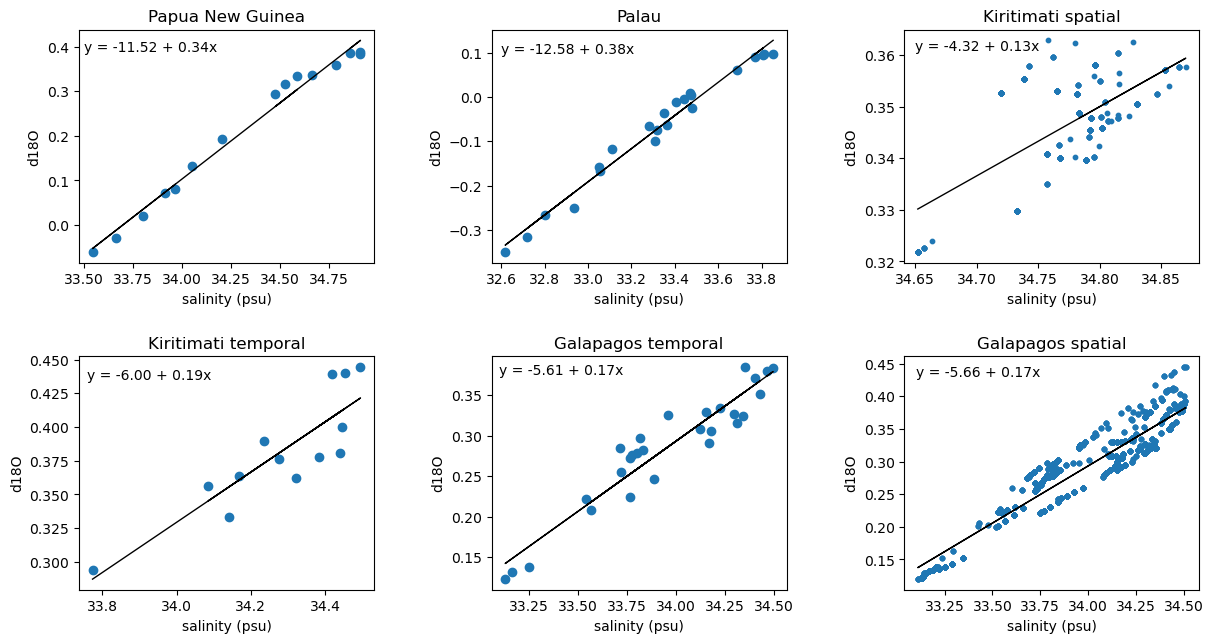

In [36]:
# subplots of subsampled data for each of the 6 datasets
plt.figure(figsize=(14,7))

plt.subplot(2,3,1)
plt.scatter(png_salt_data,png_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Papua New Guinea")
a, b = np.polyfit(png_salt_data,png_d18O_data,1)
plt.plot(png_salt_data, a*png_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text(33.5, 0.39, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplot(2,3,2)
plt.scatter(palau_salt_data,palau_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Palau")
a, b = np.polyfit(palau_salt_data,palau_d18O_data,1)
plt.plot(palau_salt_data, a*palau_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text(32.6, 0.1, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplot(2,3,3)
plt.scatter(kiri_s_salt_data_f,kiri_s_d18O_data_f, s=10)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Kiritimati spatial")
a, b = np.polyfit(kiri_s_salt_data_fa,kiri_s_d18O_data_fa,1)
plt.plot(kiri_s_salt_data_fa, a*kiri_s_salt_data_fa+b, color='black', linestyle='-', linewidth=1)
plt.text(34.65, 0.361, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplot(2,3,4)
plt.scatter(kiri_t_salt_data,kiri_t_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Kiritimati temporal")
a, b = np.polyfit(kiri_t_salt_data,kiri_t_d18O_data,1)
plt.plot(kiri_t_salt_data, a*kiri_t_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text(33.76, 0.435, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplot(2,3,5)
plt.scatter(gala_t_salt_data,gala_t_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Galapagos temporal")
a, b = np.polyfit(gala_t_salt_data,gala_t_d18O_data,1)
plt.plot(gala_t_salt_data, a*gala_t_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text(33.10, 0.375, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplot(2,3,6)
plt.scatter(gala_s_salt_data_f,gala_s_d18O_data_f,s = 10)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Galapagos spatial")
a, b = np.polyfit(gala_s_salt_data_fa,gala_s_d18O_data_fa,1)
plt.plot(gala_s_salt_data_fa, a*gala_s_salt_data_fa+b, color='black', linestyle='-', linewidth=1)
plt.text(33.1, 0.43, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [37]:
# d18O from 850-1850
d18O_mil = xr.open_dataarray('/data/keeling/a/anayrp2/CESM/d18O_mil.nc')

In [38]:
# salinity from 850-1850
salt_mil = xr.open_dataarray('/data/keeling/a/anayrp2/CESM/salt_mil.nc')

In [39]:
d18O_mil.load();

In [40]:
salt_mil.load();

In [41]:
# the same plucking is now done for this pre-industrial millenium data below

In [42]:
lat_target=-2.061
lon_target=147.428
png_d18O_mil =pluck_data(d18O_mil,lon_target,lat_target)

In [43]:
lat_target=-2.061
lon_target=147.428
png_salt_mil=pluck_data(salt_mil,lon_target,lat_target)

In [44]:
lat_target = 7.317
lon_target = 134.461 
palau_d18O_mil= pluck_data(d18O_mil, lon_target, lat_target)

In [45]:
lat_target = 7.317
lon_target = 134.461 
palau_salt_mil= pluck_data(salt_mil, lon_target, lat_target)

In [46]:
lat_target = 2.0
lon_target = -157.483
kiri_t_d18O_mil= pluck_data(d18O_mil, lon_target, lat_target)

In [47]:
lat_target = 2.0
lon_target = -157.483
kiri_t_salt_mil= pluck_data(salt_mil, lon_target, lat_target)

In [48]:
lat_target = -0.744
lon_target = -90.303
gala_t_d18O_mil= pluck_data(d18O_mil, lon_target, lat_target)

In [49]:
lat_target = -0.744
lon_target = -90.303
gala_t_salt_mil= pluck_data(salt_mil, lon_target, lat_target)

In [50]:
kiri_s_d18O_mil = []
for i in range(139,162):
    lon_target = kiri_s['Lon']
    lat_target = kiri_s['Lat']
    kiri_s_d18O_mil.append(pluck_data(d18O_mil, lon_target[i], lat_target[i]))
kiri_s_d18O_mil_f = list(np.concatenate(kiri_s_d18O_mil).flat)

In [51]:
kiri_s_salt_mil = []
for i in range(139,162):
    lon_target = kiri_s['Lon']
    lat_target = kiri_s['Lat']
    kiri_s_salt_mil.append(pluck_data(salt_mil, lon_target[i], lat_target[i]))
kiri_s_salt_mil_f = list(np.concatenate(kiri_s_salt_mil).flat)

In [52]:
gala_s_d18O_mil = []
for i in range(328,465):
    lon_target = gala_s['Lon']
    lat_target = gala_s['Lat']
    gala_s_d18O_mil.append(pluck_data(d18O_mil, lon_target[i], lat_target[i]))
gala_s_d18O_mil_f = list(np.concatenate(gala_s_d18O_mil).flat)

In [53]:
gala_s_salt_mil = []
for i in range(328,465):
    lon_target = gala_s['Lon']
    lat_target = gala_s['Lat']
    gala_s_salt_mil.append(pluck_data(salt_mil, lon_target[i], lat_target[i]))
gala_s_salt_mil_f = list(np.concatenate(gala_s_salt_mil).flat)

In [54]:
kiri_s_salt_mil_fa = np.array(kiri_s_salt_mil_f)
kiri_s_d18O_mil_fa = np.array(kiri_s_d18O_mil_f)
gala_s_salt_mil_fa = np.array(gala_s_salt_mil_f)
gala_s_d18O_mil_fa = np.array(gala_s_d18O_mil_f)

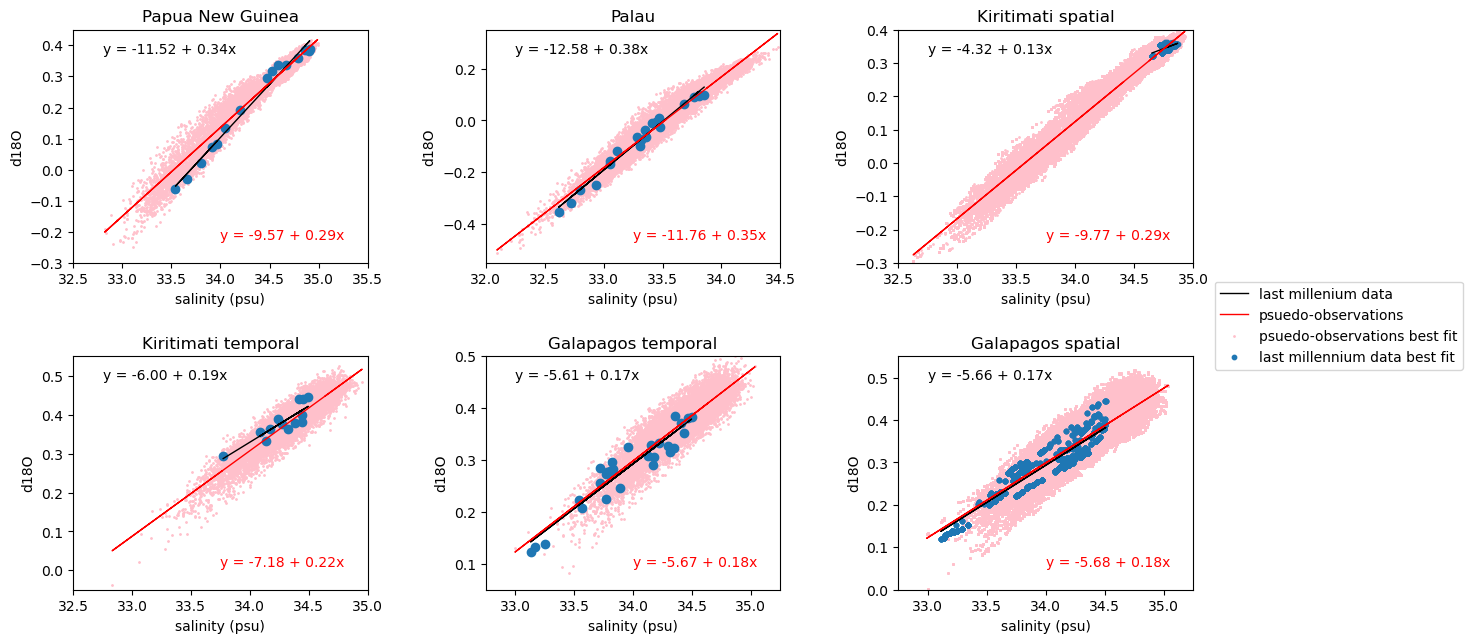

In [55]:
# the subsampled data from above is now plotted alongside the 850-1850 data, along with their respective best fit lines
# this graph is with d18O as the response variable

kiri_out = stats.linregress(kiri_s_salt_mil_fa,kiri_s_d18O_mil_fa)
gala_out = stats.linregress(gala_s_salt_mil_fa,gala_s_d18O_mil_fa)
plt.figure(figsize=(14,7))

plt.subplot(2,3,1)
plt.scatter(png_salt_mil,png_d18O_mil,color='pink',s=1)
plt.scatter(png_salt_data,png_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Papua New Guinea")
a, b = np.polyfit(png_salt_data,png_d18O_data,1)
plt.plot(png_salt_data, a*png_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text((35.5 - ((35.5-32.5)*0.9)),(0.45 - ((0.45+0.3)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(png_salt_mil,png_d18O_mil,1)
plt.plot(png_salt_mil, c*png_salt_mil+d, color='red', linestyle='-', linewidth=1)
plt.text((35.5 - ((35.5-32.5)*0.5)),(0.45 - ((0.45+0.3)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32.5,35.5)
plt.ylim(-0.3,0.45)

plt.subplot(2,3,2)
plt.scatter(palau_salt_mil,palau_d18O_mil,color='pink',s=1)
plt.scatter(palau_salt_data,palau_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Palau")
a, b = np.polyfit(palau_salt_data,palau_d18O_data,1)
plt.plot(palau_salt_data, a*palau_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text((34.5 - ((34.5-32)*0.9)), (0.35 - ((0.35+0.55)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(palau_salt_mil,palau_d18O_mil,1)
plt.plot(palau_salt_mil, c*palau_salt_mil+d, color='red', linestyle='-', linewidth=1)
plt.text((34.5 - ((34.5-32)*0.5)), (0.35 - ((0.35+0.55)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32,34.5)
plt.ylim(-0.55,0.35)

plt.subplot(2,3,3)
plt.scatter(kiri_s_salt_mil,kiri_s_d18O_mil,color='pink',s=1)
plt.scatter(kiri_s_salt_data_f,kiri_s_d18O_data_f, s=10)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Kiritimati spatial")
a, b = np.polyfit(kiri_s_salt_data_fa,kiri_s_d18O_data_fa,1)
plt.plot(kiri_s_salt_data_fa, a*kiri_s_salt_data_fa+b, color='black', linestyle='-', linewidth=1)
plt.text((35 - ((35-32.5)*0.9)), (0.4 - ((0.4+0.3)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
#c, d = np.polyfit(kiri_s_salt_mil_fa,kiri_s_d18O_mil_fa,1)
c = kiri_out.slope
d = kiri_out.intercept
plt.plot(kiri_s_salt_mil_fa, c*kiri_s_salt_mil_fa+d, color='red', linestyle='-', linewidth=1)
plt.text((35 - ((35-32.5)*0.5)), (0.4 - ((0.4+0.3)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32.5,35)
plt.ylim(-0.3,0.4)

plt.subplot(2,3,4)
plt.scatter(kiri_t_salt_mil,kiri_t_d18O_mil,color='pink',s=1)
plt.scatter(kiri_t_salt_data,kiri_t_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Kiritimati temporal")
a, b = np.polyfit(kiri_t_salt_data,kiri_t_d18O_data,1)
plt.plot(kiri_t_salt_data, a*kiri_t_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text((35 - ((35-32.5)*0.9)), (0.55 - ((0.55+0.05)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(kiri_t_salt_mil,kiri_t_d18O_mil,1)
plt.plot(kiri_t_salt_mil, c*kiri_t_salt_mil+d, color='red', linestyle='-', linewidth=1)
plt.text((35 - ((35-32.5)*0.5)), (0.55 - ((0.55+0.05)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32.5,35)
plt.ylim(-0.05,0.55)

plt.subplot(2,3,5)
plt.scatter(gala_t_salt_mil,gala_t_d18O_mil,color='pink',s=1)
plt.scatter(gala_t_salt_data,gala_t_d18O_data)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Galapagos temporal")
a, b = np.polyfit(gala_t_salt_data,gala_t_d18O_data,1)
plt.plot(gala_t_salt_data, a*gala_t_salt_data+b, color='black', linestyle='-', linewidth=1)
plt.text((35.25 - ((35.25-32.75)*0.9)), (0.5 - ((0.5-0.05)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(gala_t_salt_mil,gala_t_d18O_mil,1)
plt.plot(gala_t_salt_mil, c*gala_t_salt_mil+d, color='red', linestyle='-', linewidth=1)
plt.text((35.25 - ((35.25-32.75)*0.5)), (0.5 - ((0.5-0.05)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32.75,35.25)
plt.ylim(0.05,0.5)

plt.subplot(2,3,6)
plt.scatter(gala_s_salt_mil,gala_s_d18O_mil,color='pink',s=1)
plt.scatter(gala_s_salt_data_f,gala_s_d18O_data_f,s = 10)
plt.xlabel("salinity (psu)")
plt.ylabel("d18O")
plt.title("Galapagos spatial")
a, b = np.polyfit(gala_s_salt_data_fa,gala_s_d18O_data_fa,1)
plt.plot(gala_s_salt_data_fa, a*gala_s_salt_data_fa+b, color='black', linestyle='-', linewidth=1)
plt.text((35.25 - ((35.25-32.75)*0.9)), (0.55 - ((0.55)*0.1)), 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
#c, d = np.polyfit(gala_s_salt_mil_fa,gala_s_d18O_mil_fa,1)
c = gala_out.slope
d = gala_out.intercept
plt.plot(gala_s_salt_mil_fa, c*gala_s_salt_mil_fa+d, color='red', linestyle='-', linewidth=1)
plt.text((35.25 - ((35.25-32.75)*0.5)), (0.55 - ((0.55)*0.9)), 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')
plt.xlim(32.75,35.25)
plt.ylim(0,0.55)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.legend(["last millenium data", "psuedo-observations",'psuedo-observations best fit','last millennium data best fit'],bbox_to_anchor=(1.05, 1.35),loc='upper left')

plt.show()


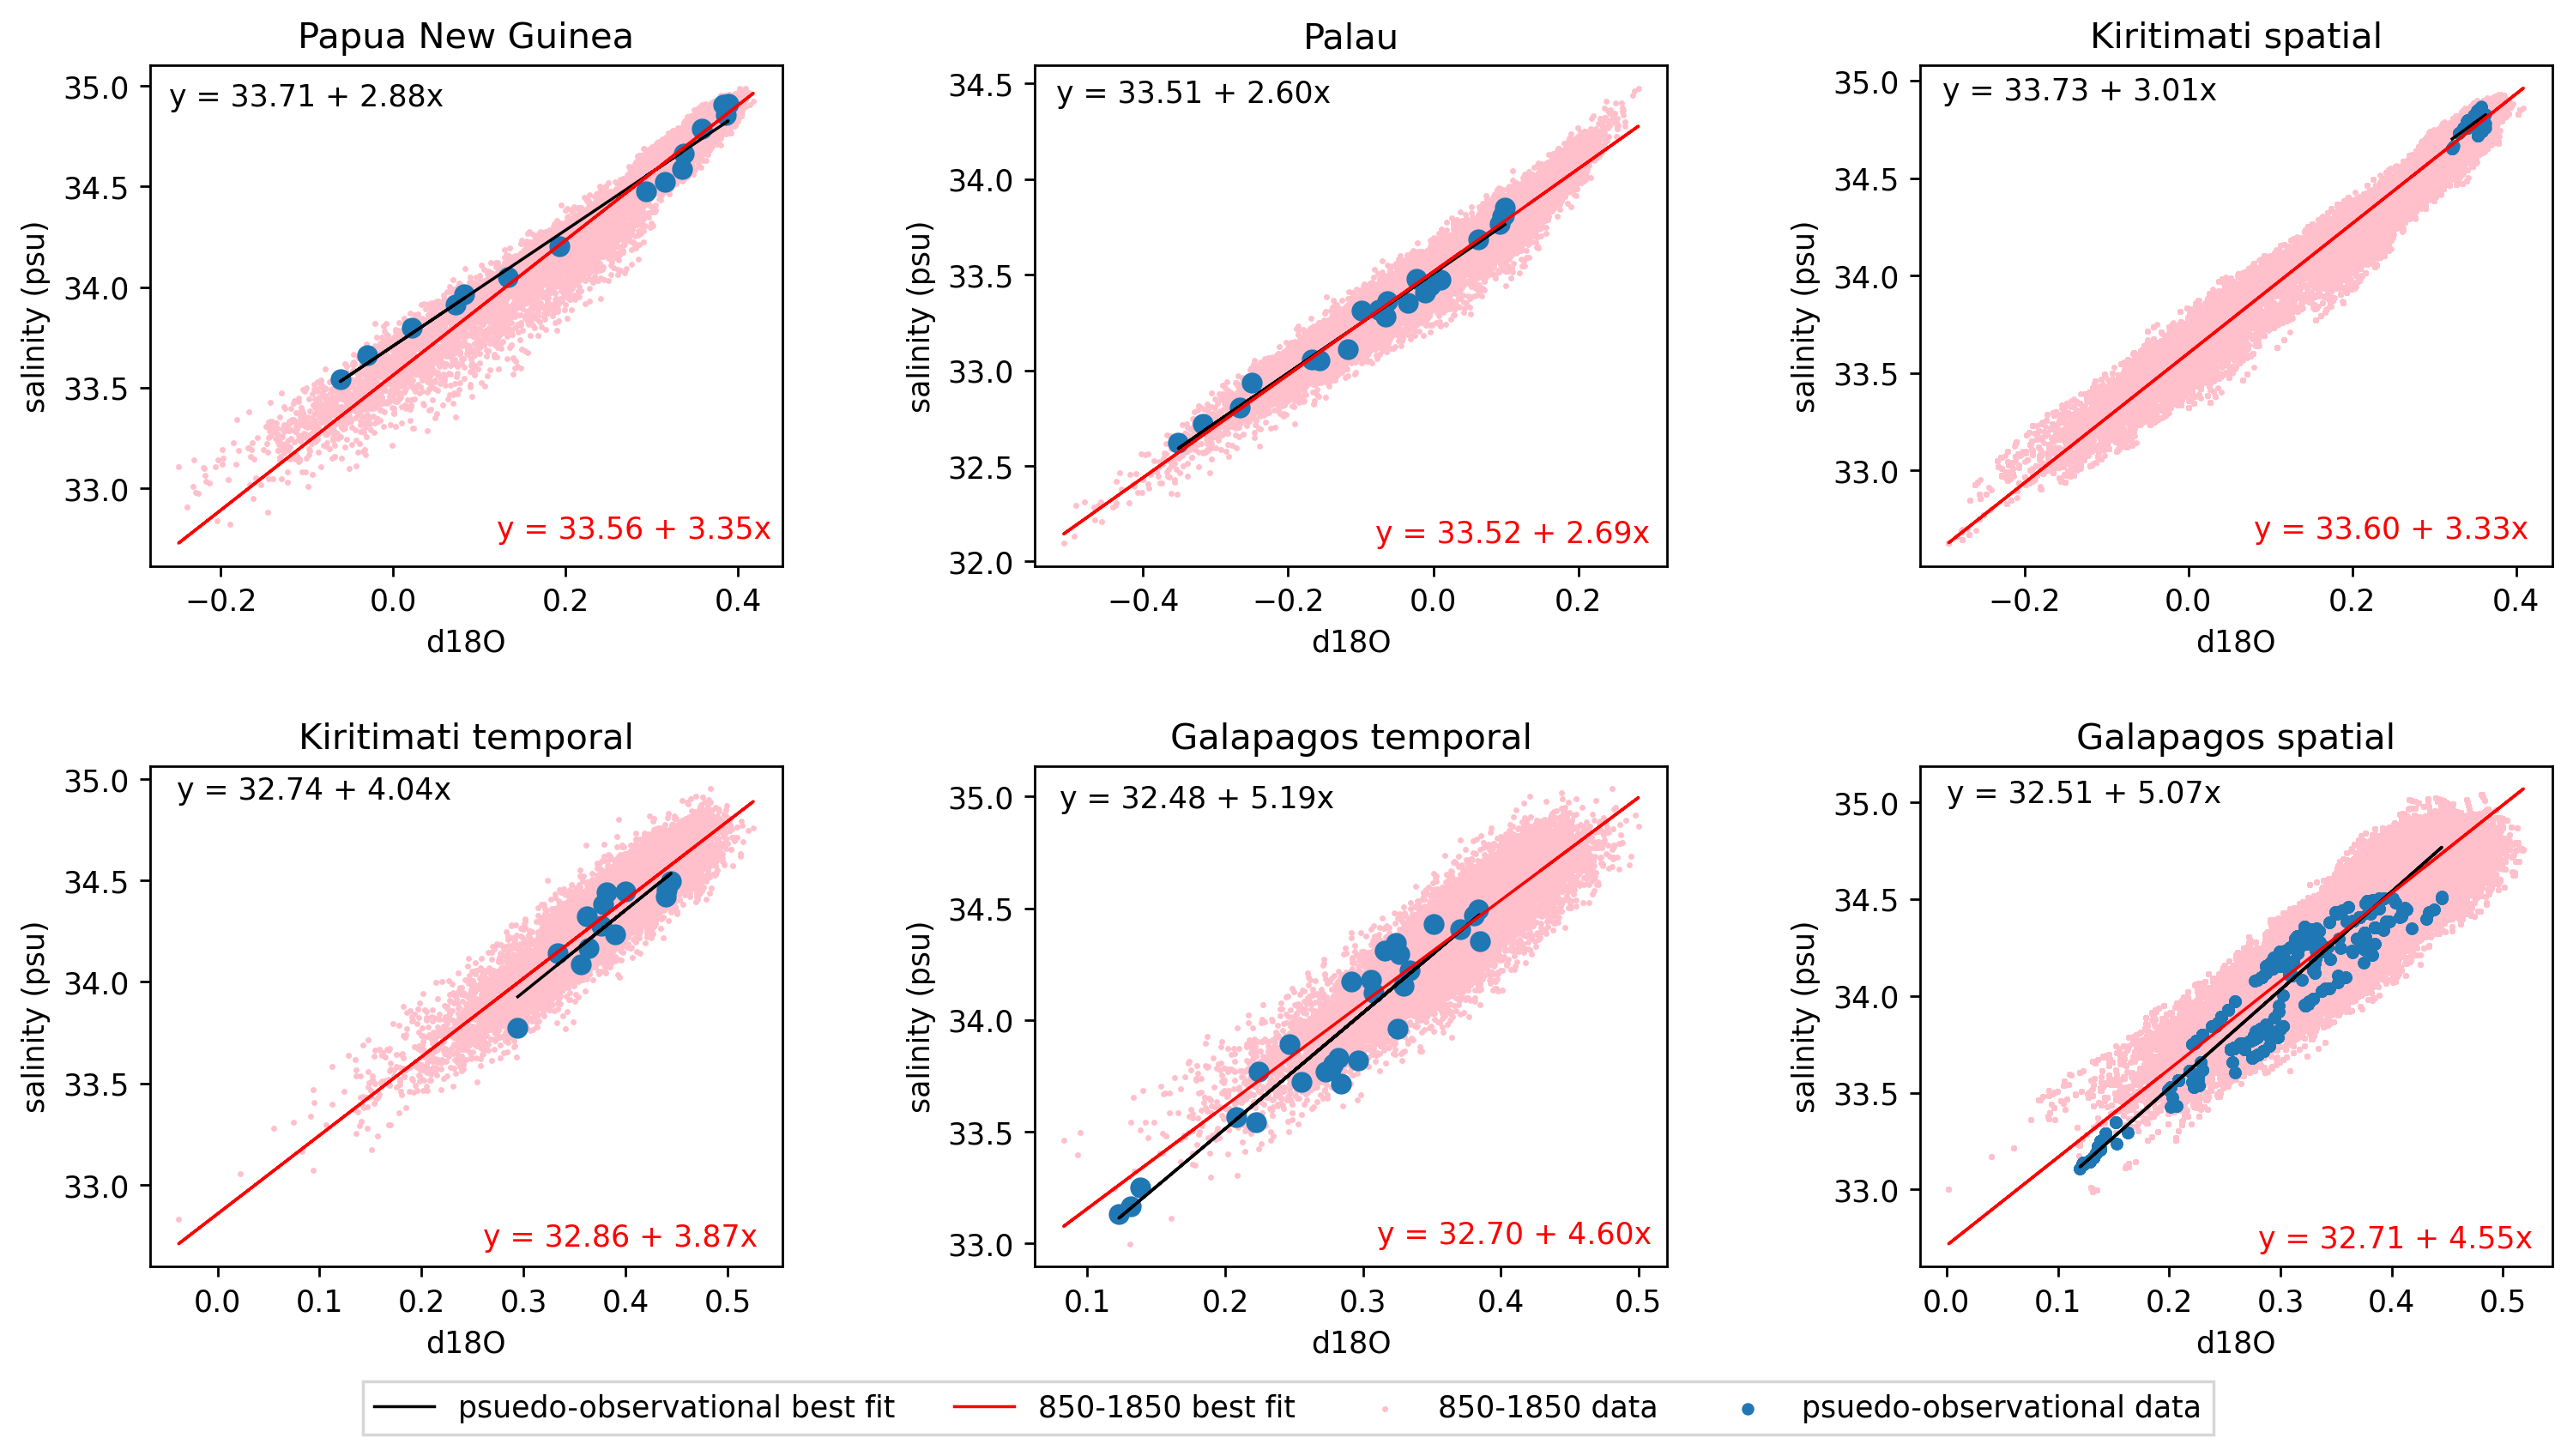

In [56]:
# same plot as above but with salinity as the response variable

kiri_out = stats.linregress(kiri_s_d18O_mil_fa,kiri_s_salt_mil_fa)
gala_out = stats.linregress(gala_s_d18O_mil_fa,gala_s_salt_mil_fa)

plt.figure(figsize=(14,7), dpi=250)

plt.subplot(2,3,1)
plt.scatter(png_d18O_mil,png_salt_mil,color='pink',s=1)
plt.scatter(png_d18O_data,png_salt_data)
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Papua New Guinea")
a, b = np.polyfit(png_d18O_data,png_salt_data,1)
plt.plot(png_d18O_data, a*png_d18O_data+b, color='black', linestyle='-', linewidth=1)
plt.text(-0.26,34.9, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(png_d18O_mil,png_salt_mil,1)
plt.plot(png_d18O_mil, c*png_d18O_mil+d, color='red', linestyle='-', linewidth=1)
plt.text(0.12,32.75, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplot(2,3,2)
plt.scatter(palau_d18O_mil,palau_salt_mil,color='pink',s=1)
plt.scatter(palau_d18O_data,palau_salt_data)
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Palau")
a, b = np.polyfit(palau_d18O_data,palau_salt_data,1)
plt.plot(palau_d18O_data, a*palau_d18O_data+b, color='black', linestyle='-', linewidth=1)
plt.text(-0.52, 34.4, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(palau_d18O_mil,palau_salt_mil,1)
plt.plot(palau_d18O_mil, c*palau_d18O_mil+d, color='red', linestyle='-', linewidth=1)
plt.text(-0.08,32.1, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplot(2,3,3)
plt.scatter(kiri_s_d18O_mil,kiri_s_salt_mil,color='pink',s=1)
plt.scatter(kiri_s_d18O_data_f,kiri_s_salt_data_f, s=10)
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Kiritimati spatial")
a, b = np.polyfit(kiri_s_d18O_data_fa,kiri_s_salt_data_fa,1)
plt.plot(kiri_s_d18O_data_fa, a*kiri_s_d18O_data_fa+b, color='black', linestyle='-', linewidth=1)
plt.text( -0.3,34.9, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
#c, d = np.polyfit(kiri_s_salt_mil_fa,kiri_s_d18O_mil_fa,1)
c = kiri_out.slope
d = kiri_out.intercept
plt.plot(kiri_s_d18O_mil_fa, c*kiri_s_d18O_mil_fa+d, color='red', linestyle='-', linewidth=1)
plt.text( 0.08,32.65, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplot(2,3,4)
plt.scatter(kiri_t_d18O_mil,kiri_t_salt_mil,color='pink',s=1)
plt.scatter(kiri_t_d18O_data,kiri_t_salt_data)
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Kiritimati temporal")
a, b = np.polyfit(kiri_t_d18O_data,kiri_t_salt_data,1)
plt.plot(kiri_t_d18O_data, a*kiri_t_d18O_data+b, color='black', linestyle='-', linewidth=1)
plt.text( -0.04,34.9, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(kiri_t_d18O_mil,kiri_t_salt_mil,1)
plt.plot(kiri_t_d18O_mil, c*kiri_t_d18O_mil+d, color='red', linestyle='-', linewidth=1)
plt.text( 0.26,32.7, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplot(2,3,5)
plt.scatter(gala_t_d18O_mil,gala_t_salt_mil,color='pink',s=1)
plt.scatter(gala_t_d18O_data,gala_t_salt_data)
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Galapagos temporal")
a, b = np.polyfit(gala_t_d18O_data,gala_t_salt_data,1)
plt.plot(gala_t_d18O_data, a*gala_t_d18O_data+b, color='black', linestyle='-', linewidth=1)
plt.text(0.08, 34.95, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
c, d = np.polyfit(gala_t_d18O_mil,gala_t_salt_mil,1)
plt.plot(gala_t_d18O_mil, c*gala_t_d18O_mil+d, color='red', linestyle='-', linewidth=1)
plt.text(0.31, 33, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplot(2,3,6)
plt.scatter(gala_s_d18O_mil,gala_s_salt_mil,color='pink',s=1,label="850-1850 data")
plt.scatter(gala_s_d18O_data_f,gala_s_salt_data_f,s = 10,label="psuedo-observational data")
plt.xlabel("d18O")
plt.ylabel("salinity (psu)")
plt.title("Galapagos spatial")
a, b = np.polyfit(gala_s_d18O_data_fa,gala_s_salt_data_fa,1)
plt.plot(gala_s_d18O_data_fa, a*gala_s_d18O_data_fa+b, color='black', linestyle='-', linewidth=1,label="psuedo-observational best fit")
plt.text(0, 35, 'y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x', size=10)
#c, d = np.polyfit(gala_s_salt_mil_fa,gala_s_d18O_mil_fa,1)
c = gala_out.slope
d = gala_out.intercept
plt.plot(gala_s_d18O_mil_fa, c*gala_s_d18O_mil_fa+d, color='red', linestyle='-', linewidth=1,label="850-1850 best fit")
plt.text(0.28, 32.7, 'y = ' + '{:.2f}'.format(d) + ' + {:.2f}'.format(c) + 'x', size=10,color='red')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#plt.legend(["last millenium data", "psuedo-observations",'psuedo-observations best fit','last millennium data best fit'],
#           bbox_to_anchor=(-1, -0.2),loc='upper center',fancybox=False, shadow=False, ncol=4)
plt.legend(bbox_to_anchor=(-1, -0.2),loc='upper center',fancybox=False, shadow=False, ncol=4)

plt.show()


In [57]:
# worldwide coral dataset
# manually removed rows with duplicate locations in csv file
# also went back and removed any rows that produced NaN data
corals = pd.read_csv('/data/keeling/a/anayrp2/CESM/iso2Kcoral_recordsThompson2022_fixed2.csv')

In [58]:
# for col in corals.columns:
#     print(col)

In [59]:
# collecting the coordinates and time periods to subsample iCESM from for each coral
# also changed some of the data types

In [60]:
corals_lats = []
corals_lon = []
corals_min_years = []
corals_max_years = []

In [61]:
for i in range(43):
    corals_lats = np.append(corals_lats, corals['lat'][i])

In [62]:
for i in range(43):
    corals_lon = np.append(corals_lon, corals['lon'][i])

In [63]:
for i in range(43):
    corals_min_years = np.append(corals_min_years, round(corals['min year'][i]))

In [64]:
for i in range(43):
    corals_max_years = np.append(corals_max_years, round(corals['max year'][i]))

In [65]:
corals_min_years_int = corals_min_years.astype(int)
corals_min_years_str = corals_min_years_int.astype(str)
corals_max_years_int = corals_max_years.astype(int)
corals_max_years_str = corals_max_years_int.astype(str)

In [66]:
# this was needed before I removed some of the rows, will be useful if some corals are reintroduced into analysis
for i in range(43):
    if len(corals_min_years_str[i]) < 4:
        corals_min_years_str[i] = '0' + corals_min_years_str[i]
corals_min_years_str

array(['1801', '1879', '1840', '1881', '1782', '1860', '1941', '1929',
       '1727', '1910', '1961', '1832', '1790', '1867', '1708', '1858',
       '1872', '1886', '1843', '1950', '1959', '1914', '1899', '1848',
       '1959', '1953', '1987', '1954', '1884', '1808', '1936', '1894',
       '1607', '1923', '1807', '1847', '1852', '1938', '1658', '1939',
       '1638', '1952', '1795'], dtype='<U21')

In [67]:
corals_lons = corals_lon.astype(float)

In [68]:
# defining the initial training period (most recent 5 years of iCESM)
coral_salt_train_time = salt_last_sw.sel(time=slice('2000-01', '2006-01'))
coral_d18O_train_time = d18O_last_sw.sel(time=slice('2000-01', '2006-01'))

In [69]:
# function to get the training salinity data at any coral (i)
def get_salt_train(i):
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    return pluck_data(coral_salt_train_time, lon_target, lat_target)

In [70]:
# function to get the training d18O data at any coral (i)
def get_d18O_train(i):
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    return pluck_data(coral_d18O_train_time, lon_target, lat_target)

In [71]:
# making a combined iCESM dataset from 850-2005
# should have moved this to preprocessing notebook, might do that later
salt_all = xr.concat([salt_mil, salt_last_sw], dim='time')
d18O_all = xr.concat([d18O_mil, d18O_last_sw], dim='time')

In [72]:
salt_all.load();
d18O_all.load();

In [73]:
# function to get the test salinity data at any coral (i) based on the bounds of its lifespan
def get_salt_test(i):
    #coral_d18O_test_data = np.array([])
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    coral_salt_test_time = salt_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    return pluck_data(coral_salt_test_time, lon_target, lat_target)

In [74]:
# function to get the test d18O data at any coral (i) based on the bounds of its lifespan
def get_d18O_test(i):
    #coral_d18O_test_data = np.array([])
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    coral_d18O_test_time = d18O_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    return pluck_data(coral_d18O_test_time, lon_target, lat_target)

In [75]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [76]:
# this function computes the r^2 between y test and y hat
# a model is first trained on the 5 years of training data
# the model is then fed in the d18O values from the testing period, giving us a predicted salinity
# a regression is then used between y test and y hat to compute the r^2
def y_compare(i):
    x_tr_np = get_d18O_train(i).to_numpy()
    if(np.isnan(x_tr_np).any()):
        print("This array contains NaN values.")
        return
    x_tr_np2d = x_tr_np.reshape(-1,1)
    train_fit = lr.fit(x_tr_np2d, get_salt_train(i))
    x_te_np = get_d18O_test(i).to_numpy()
    x_te_np2d = x_te_np.reshape(-1,1)
    yhat = (train_fit.coef_ * x_te_np2d) + train_fit.intercept_
    compare = lr.fit(yhat, get_salt_test(i))
    return compare.score(yhat, get_salt_test(i))

In [77]:
# making an array of the r^2 for each coral
rsq = np.array([])
for i in range(43):
    rsq = np.append(rsq, y_compare(i))

In [78]:
# taking the lowest and highest 3 r^2 corals
sorted_ind = np.argsort(rsq)
sorted_rsq = rsq[sorted_ind]
result_min_ind = sorted_ind[:3]
result_max_ind = sorted_ind[-3:]
result_min_rsq = sorted_rsq[:3]
result_max_rsq = sorted_rsq[-3:]

In [79]:
print(result_min_ind, result_min_rsq)
print(result_max_ind, result_max_rsq)

[28 36 34] [0.75688752 0.78372043 0.78444574]
[35 24 15] [0.957158   0.95937872 0.96056983]


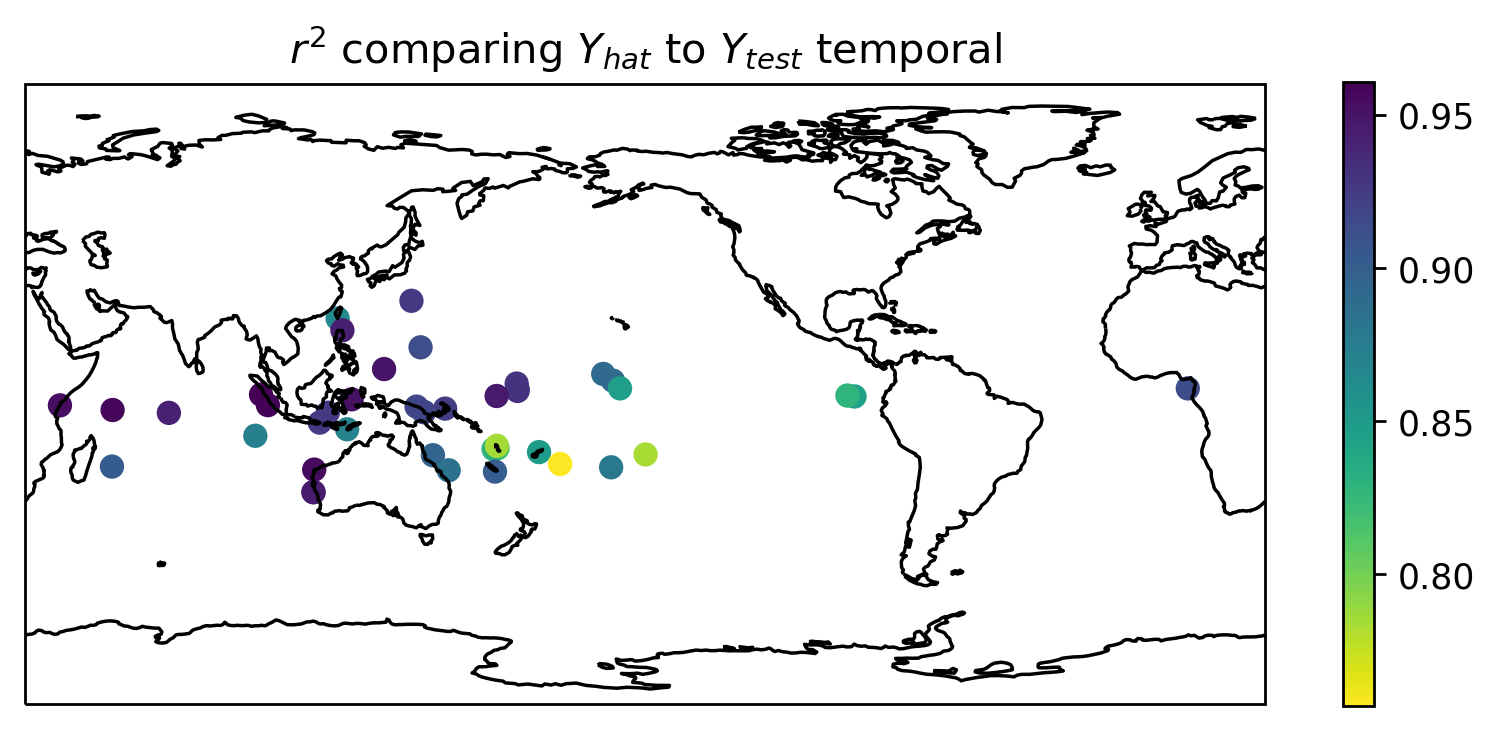

In [80]:
# map of r^2 points globally
fig = plt.figure(figsize=(8,6), dpi=250)

ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree(central_longitude=-150))

ax.add_feature(cfeature.COASTLINE)

ax.set_global()
plt.scatter(x=corals_lons, y=corals_lats,
            c= rsq,
            cmap = 'viridis_r',
            alpha=1,
            transform=ccrs.PlateCarree())
plt.colorbar(shrink=0.54)

plt.title('$r^2$ comparing $Y_{hat}$ to $Y_{test}$ temporal')
plt.show()

In [81]:
# a function to create monthly dates given the start and end year of the coral
def time_axis(i):
    return np.linspace(corals_min_years[i], corals_max_years[i], num = len(get_salt_test(i)))

In [82]:
# a function to split the training period (5 years) into monthly dates
def time_axis_train(i):
    return np.linspace(2000, 2006, num = len(get_salt_train(i)))

In [83]:
# array of indices of min and max r^2 corals
min_inds = np.array(result_min_ind)
max_inds = np.array(result_max_ind)

In [84]:
# a function to just compute y hat for visualization purposes
def y_hat(i):
    x_tr_np = get_d18O_train(i).to_numpy()
    x_tr_np2d = x_tr_np.reshape(-1,1)
    train_fit = lr.fit(x_tr_np2d, get_salt_train(i))
    x_te_np = get_d18O_test(i).to_numpy()
    x_te_np2d = x_te_np.reshape(-1,1)
    return (train_fit.coef_ * x_te_np2d) + train_fit.intercept_

In [85]:
# START OF FINALIZED FIGURES

<Figure size 1600x1200 with 0 Axes>

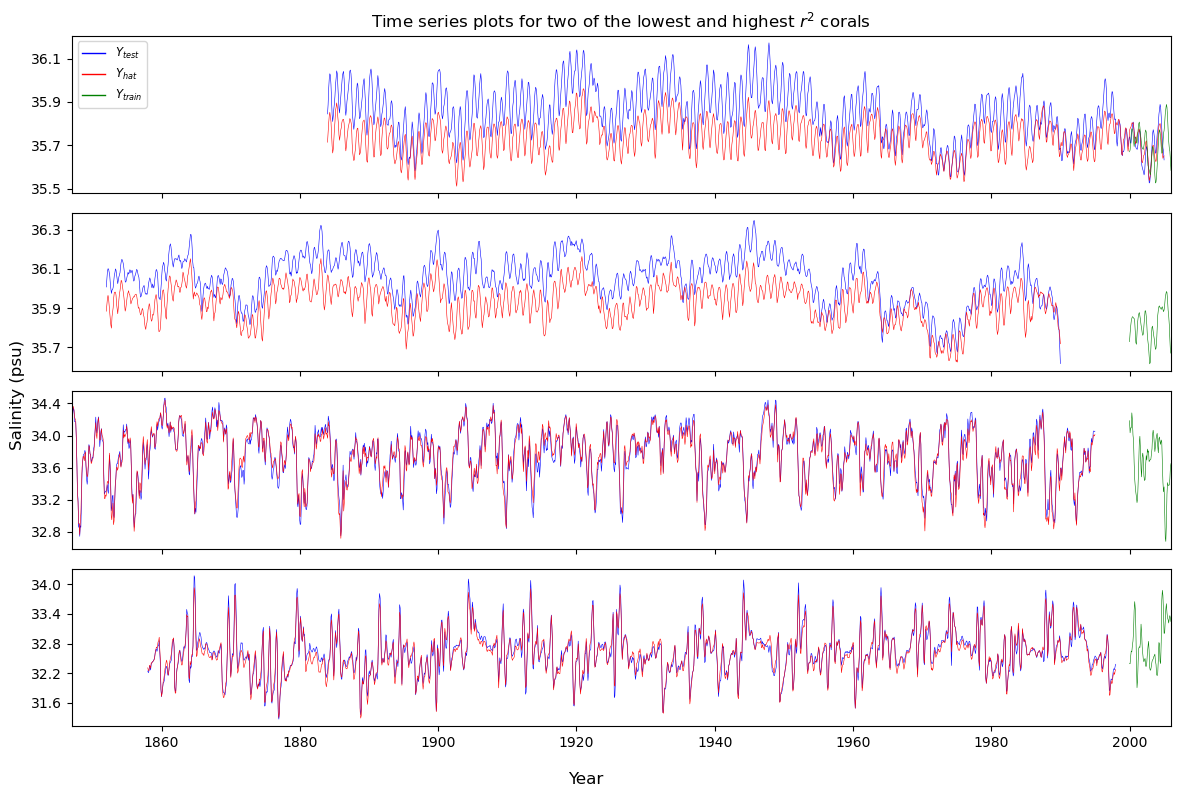

In [86]:
# time series plot showing y test vs y hat (y train also plotted) for the lowest and highest 2 r^2 corals
# x axis is shared but y axis is specific to the corals
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=1),
                Line2D([0], [0], color='red', lw=1),
                Line2D([0], [0], color='green', lw=1)]
fig = plt.figure(figsize=(16,12))
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(12,8),sharex=True, sharey=False)

ax1.plot(time_axis(min_inds[0]), get_salt_test(min_inds[0]),linewidth=0.4,color='blue')
ax1.plot(time_axis(min_inds[0]), y_hat(min_inds[0]),linewidth=0.4,color='red')
ax1.plot(time_axis_train(min_inds[0]), get_salt_train(min_inds[0]), linewidth=0.4, color='green')
ax1.set_title('Time series plots for two of the lowest and highest $r^2$ corals')
ax1.yaxis.set_ticks(np.arange(35.5, 36.3, 0.2))
ax1.margins(x=0)
ax1.legend(custom_lines, ['$Y_{test}$', '$Y_{hat}$', '$Y_{train}$'],loc='upper left',fontsize='small')

ax2.plot(time_axis(min_inds[1]), get_salt_test(min_inds[1]),linewidth=0.4,color='blue')
ax2.plot(time_axis(min_inds[1]), y_hat(min_inds[1]),linewidth=0.4,color='red')
ax2.plot(time_axis_train(min_inds[1]), get_salt_train(min_inds[1]), linewidth=0.4, color='green')
ax2.yaxis.set_ticks(np.arange(35.70, 36.31, 0.20))
ax2.margins(x=0)

ax3.plot(time_axis(max_inds[0]), get_salt_test(max_inds[0]),linewidth=0.4,color='blue')
ax3.plot(time_axis(max_inds[0]), y_hat(max_inds[0]),linewidth=0.4,color='red')
ax3.plot(time_axis_train(max_inds[0]), get_salt_train(max_inds[0]), linewidth=0.4, color='green')
ax3.yaxis.set_ticks(np.arange(32.8, 34.41, 0.4))
ax3.margins(x=0)

ax4.plot(time_axis(max_inds[2]), get_salt_test(max_inds[2]),linewidth=0.4,color='blue')
ax4.plot(time_axis(max_inds[2]), y_hat(max_inds[2]),linewidth=0.4,color='red')
ax4.plot(time_axis_train(max_inds[2]), get_salt_train(max_inds[2]), linewidth=0.4, color='green')
ax4.yaxis.set_ticks(np.arange(31.6, 34.01, 0.6))
ax4.margins(x=0)

f.supxlabel('Year')
f.supylabel('Salinity (psu)')

f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.tight_layout()

In [88]:
import seaborn as sb

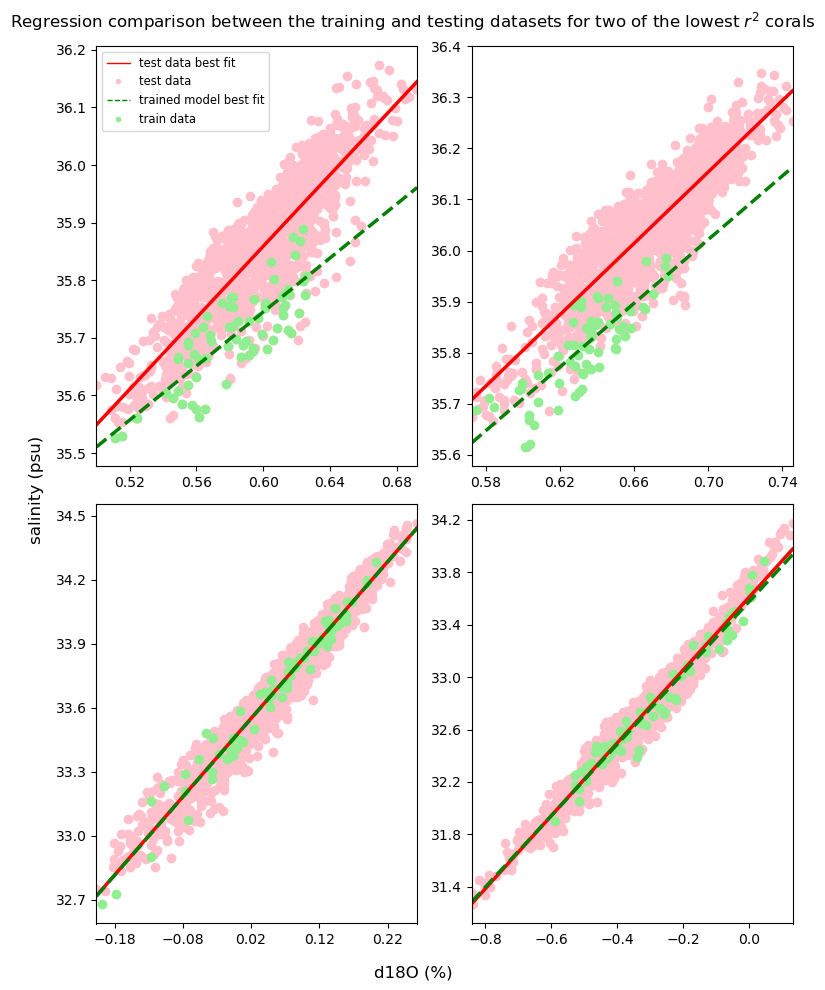

In [89]:
# scatter plots for both training and testing data is plotted, as well as their best fit lines, for the same corals as above
fig = plt.figure(figsize=(8,10))
plt.suptitle('Regression comparison between the training and testing datasets for two of the lowest $r^2$ corals')

legend_elements = [Line2D([0], [0], color='red', lw=1, label='test data best fit'),
                   Line2D([0], [0], marker='o', color='white', label='test data',
                          markerfacecolor='pink', markersize=5),
                   Line2D([0], [0], color='green', lw=1, linestyle='--',label='trained model best fit'),
                   Line2D([0], [0], marker='o', color='white', label='train data',
                          markerfacecolor='lightgreen', markersize=5)]

plt.subplot(2,2,1)
plt.scatter(get_d18O_test(min_inds[0]), get_salt_test(min_inds[0]),c='pink')
plt.scatter(get_d18O_train(min_inds[0]), get_salt_train(min_inds[0]), c='lightgreen')
sb.regplot(x=get_d18O_test(min_inds[0]), y=get_salt_test(min_inds[0]),ci=None,scatter=False,color='red',
           line_kws={"linewidth": 2.5})
sb.regplot(x=get_d18O_test(min_inds[0]), y=y_hat(min_inds[0]),ci=None,scatter=False,color='green',
           line_kws={"linewidth": 2.5,"linestyle":"dashed"})
plt.margins(x=0)
plt.legend(handles=legend_elements, loc='upper left',fontsize='small')
plt.xticks(np.arange(0.52, 0.681, 0.04))
plt.yticks(np.arange(35.5, 36.21, 0.1))
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(2,2,2)
plt.scatter(get_d18O_test(min_inds[1]), get_salt_test(min_inds[1]),c='pink')
plt.scatter(get_d18O_train(min_inds[1]), get_salt_train(min_inds[1]), c='lightgreen')
sb.regplot(x=get_d18O_test(min_inds[1]), y=get_salt_test(min_inds[1]),ci=None,scatter=False,color='red',
           line_kws={"linewidth": 2.5})
sb.regplot(x=get_d18O_test(min_inds[1]), y=y_hat(min_inds[1]),ci=None,scatter=False,color='green',
           line_kws={"linewidth": 2.5,"linestyle":"dashed"})
plt.margins(x=0)
plt.xticks(np.arange(0.58, 0.75, 0.04))
plt.yticks(np.arange(35.6, 36.41, 0.1))
plt.xlabel(None)
plt.ylabel(None)

plt.subplot(2,2,3)
plt.scatter(get_d18O_test(max_inds[0]), get_salt_test(max_inds[0]),c='pink')
plt.scatter(get_d18O_train(max_inds[0]), get_salt_train(max_inds[0]), c='lightgreen')
sb.regplot(x=get_d18O_test(max_inds[0]), y=get_salt_test(max_inds[0]),ci=None,scatter=False,color='red',
           line_kws={"linewidth": 2.5})
sb.regplot(x=get_d18O_test(max_inds[0]), y=y_hat(max_inds[0]),ci=None,scatter=False,color='green',
           line_kws={"linewidth": 2.5,"linestyle":"dashed"})
plt.margins(x=0)
plt.xticks(np.arange(-0.18, 0.27, 0.1))
plt.yticks(np.arange(32.7, 34.51, 0.3))
plt.xlabel(None)
plt.ylabel(None)
    
plt.subplot(2,2,4)
plt.scatter(get_d18O_test(max_inds[2]), get_salt_test(max_inds[2]),c='pink')
plt.scatter(get_d18O_train(max_inds[2]), get_salt_train(max_inds[2]), c='lightgreen')
sb.regplot(x=get_d18O_test(max_inds[2]), y=get_salt_test(max_inds[2]),ci=None,scatter=False,color='red',
           line_kws={"linewidth": 2.5})
sb.regplot(x=get_d18O_test(max_inds[2]), y=y_hat(max_inds[2]),ci=None,scatter=False,color='green',
           line_kws={"linewidth": 2.5,"linestyle":"dashed"})
plt.margins(x=0)
plt.xticks(np.arange(-0.8, 0.06, 0.2))
plt.yticks(np.arange(31.4, 34.21, 0.4))
plt.xlabel(None)
plt.ylabel(None)


fig.supxlabel('d18O (%)')
fig.supylabel('salinity (psu)')
plt.tight_layout(pad=1)
plt.show()

In [90]:
# defining a 2d array where rows represent month pairings that make up a training period
temporal_options_raw = np.array(['2000-01', '2006-01','1995-01', '2006-01','1980-01', '2006-01'])
temporal_options = np.reshape(temporal_options_raw, (3,2))

In [91]:
# a function to return the r^2 given a coral and its training interval length 
def temporal_compare(i, d):
    coral_salt_train = salt_all.sel(time=slice(temporal_options[d][0], temporal_options[d][1]))
    coral_d18O_train = d18O_all.sel(time=slice(temporal_options[d][0], temporal_options[d][1]))
    
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    
    plucked_salt_train = pluck_data(coral_salt_train, lon_target, lat_target)
    plucked_d18O_train = pluck_data(coral_d18O_train, lon_target, lat_target)
    
    coral_salt_test = salt_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    coral_d18O_test = d18O_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    
    plucked_salt_test = pluck_data(coral_salt_test, lon_target, lat_target)
    plucked_d18O_test = pluck_data(coral_d18O_test, lon_target, lat_target)
    
    x_train_np = plucked_d18O_train.to_numpy()
    x_train_np_2d = x_train_np.reshape(-1,1)
    train_data_fit = lr.fit(x_train_np_2d, plucked_salt_train)
    x_test_np = plucked_d18O_test.to_numpy()
    x_test_np_2d = x_test_np.reshape(-1,1)
    y_hat = (train_data_fit.coef_ * x_test_np_2d) + train_data_fit.intercept_
    compare_y = lr.fit(y_hat, plucked_salt_test)
    return compare_y.score(y_hat, plucked_salt_test)

In [92]:
# defining the month (or months) that spatial data is sampled for
temporal_options_spatial = np.array(['2006-01'])
#temporal_options_spatial_longer = np.array(['2005-02', '2006-01'])

In [93]:
# a function to pluck data spatially for g grid points in either direction of the target grid cell
def pluck_spatial_data(ds_salt, ds_d18O,lon_target,lat_target,g):
    ind_lat=np.argmin(np.abs(ds_salt.TLAT[:,0].values-lat_target))
    ind_lon=np.argmin(np.abs(ds_salt.TLONG[0,:].values-lon_target))

    d18O_list=np.array([])
    salt_list=np.array([])
    
    for ilat in range(ind_lat-g, ind_lat+(g+1)):
        for ilon in range(ind_lon-g, ind_lon+(g+1)):
            if np.isnan(ds_salt[:,ilat,ilon].to_numpy()).any() == False:
                salt_list = np.append(salt_list,ds_salt[:,ilat,ilon].to_numpy())
            if np.isnan(ds_d18O[:,ilat,ilon].to_numpy()).any() == False:
                d18O_list = np.append(d18O_list,ds_d18O[:,ilat,ilon].to_numpy())
    return salt_list, d18O_list

In [94]:
# a function that returns the r^2 given a coral and spatial extent (and temporal if desired)
def spatial_compare(i, g):
    coral_salt_train_spatial = salt_all.sel(time=temporal_options_spatial[0])
    #coral_salt_train_spatial = salt_all.sel(time=slice(temporal_options_spatial_longer[0], temporal_options_spatial_longer[1]))
    coral_d18O_train_spatial = d18O_all.sel(time=temporal_options_spatial[0])
    #coral_d18O_train_spatial = d18O_all.sel(time=slice(temporal_options_spatial_longer[0], temporal_options_spatial_longer[1]))
    
    lat_target = corals_lats[i]
    lon_target = corals_lons[i]
    
    plucked_spatial_train = pluck_spatial_data(coral_salt_train_spatial, coral_d18O_train_spatial,
                                                   lon_target, lat_target, g)
    
    coral_salt_test_spatial = salt_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    coral_d18O_test_spatial = d18O_all.sel(time=slice(corals_min_years_str[i], corals_max_years_str[i]))
    
    plucked_salt_test_spatial = pluck_data(coral_salt_test_spatial, lon_target, lat_target)
    plucked_d18O_test_spatial = pluck_data(coral_d18O_test_spatial, lon_target, lat_target)
    
    x_train_np_s = plucked_spatial_train[1]
    x_train_np_s_2d = x_train_np_s.reshape(-1,1)
    train_data_fit_spatial = lr.fit(x_train_np_s_2d, plucked_spatial_train[0])
    x_test_np_s = plucked_d18O_test_spatial.to_numpy()
    x_test_np_s_2d = x_test_np_s.reshape(-1,1)
    y_hat_spatial = (train_data_fit_spatial.coef_ * x_test_np_s_2d) + train_data_fit_spatial.intercept_
    compare_y_spatial = lr.fit(y_hat_spatial, plucked_salt_test_spatial)
    return compare_y_spatial.score(y_hat_spatial,plucked_salt_test_spatial)

In [95]:
# making arrays of r^2 values for different temporal and spatial exercises
rsq_t_5 = np.array([])
for i in range(43):
    rsq_t_5 = np.append(rsq_t_5, temporal_compare(i,0))

rsq_t_10 = np.array([])
for i in range(43):
    rsq_t_10 = np.append(rsq_t_10, temporal_compare(i,1))

rsq_t_25 = np.array([])
for i in range(43):
    rsq_t_25 = np.append(rsq_t_25, temporal_compare(i,2))

rsq_spatial_3 = np.array([])
for i in range(43):
    rsq_spatial_3 = np.append(rsq_spatial_3, spatial_compare(i,1))

rsq_spatial_5 = np.array([])
for i in range(43):
    rsq_spatial_5 = np.append(rsq_spatial_5, spatial_compare(i,2))
    
rsq_spatial_7 = np.array([])
for i in range(43):
    rsq_spatial_7 = np.append(rsq_spatial_7, spatial_compare(i,3))

In [96]:
# setting up labels and values for heatmap that is pictured below the next cell
# there were 4 empty rows at the end, which is why I subtracted the 4 rows
heatmap_rows_old = corals['geo_siteName']
heatmap_rows = heatmap_rows_old[: len(heatmap_rows_old) - 4]
heatmap_cols = ['5 year training', '10 year training', '25 year training',
               '3x3 spatial training', '5x5 spatial training', '7x7 spatial training']

heatmap_data_new = np.array([rsq_t_5,rsq_t_10,rsq_t_25,rsq_spatial_3, rsq_spatial_5, rsq_spatial_7])

df_heatmap_new = pd.DataFrame(np.transpose(heatmap_data_new))

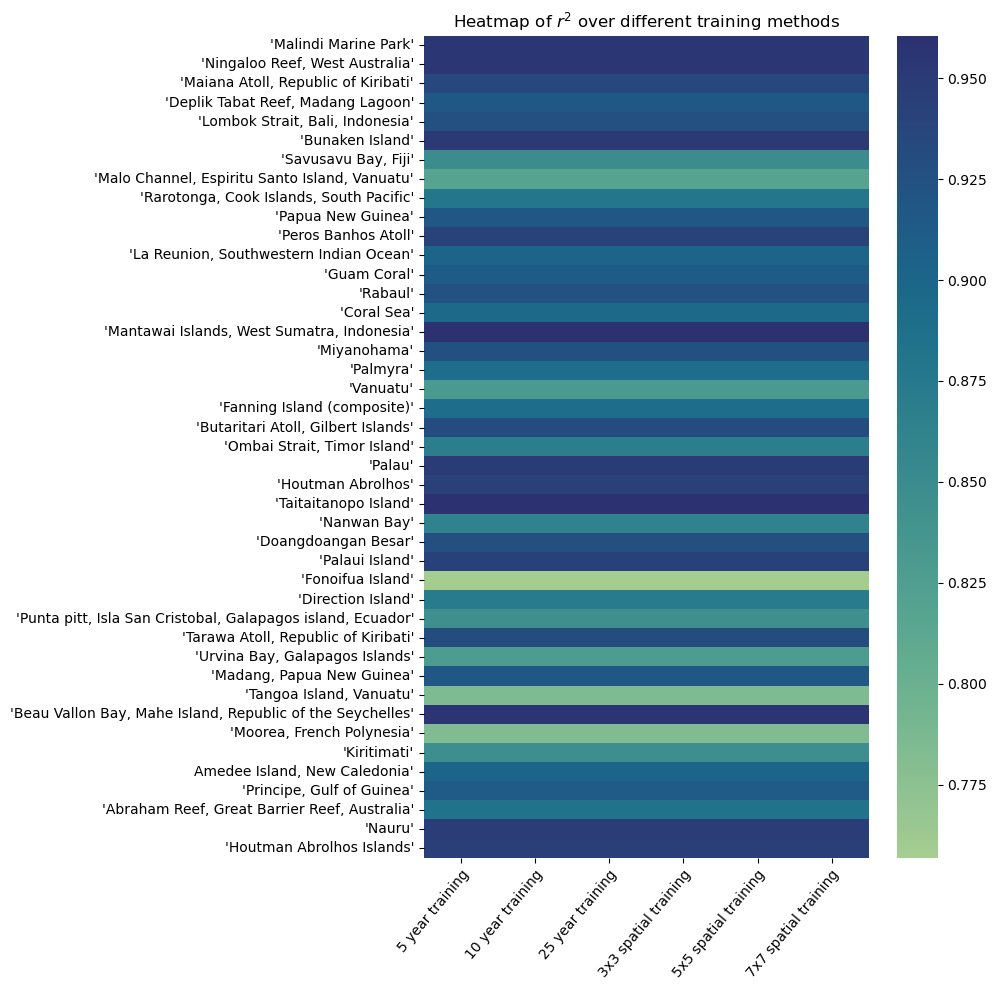

In [97]:
fig, ax = plt.subplots(figsize=(10, 10))
sb.heatmap(df_heatmap_new, xticklabels=heatmap_cols, yticklabels=heatmap_rows,cmap='crest')
plt.xticks(rotation=50,ha='right', rotation_mode='anchor')
plt.title('Heatmap of $r^2$ over different training methods')
plt.tight_layout()